In [77]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [630]:
prot_list=list(pd.read_excel("Proteins.xls"))

In [614]:
data=np.matrix(pd.read_excel("Proteins.xls"))

In [615]:
#The basics of this code is stack overflow, which I generalized
def get_one_hot(targets):
    #Need the matrix column as a row np array for the following
    targets=np.asarray(targets).reshape(-1)
    print(np.unique(targets))
    #Total number of categories in column
    num_classes=len(np.unique(targets))
    #Create an arry the same length as the column, with the entries correspond to where
    #they appear in the np.unique output, which sorts them.
    indices=np.searchsorted(np.unique(targets),targets)
    #For each index, take the corresponding column out of the identity matrix of size=number of catgories. 
    #So the third entry of the uniques array will make this return [0,0,1,0]. Does so for every index in the indices list
    res = np.eye(num_classes)[indices]
    #return as a column vector
    return res.reshape(len(targets),num_classes)

In [616]:
def mat_ohe(data,cols_to_ohe):
    #Actual data in the column passed to one hot encoder, then returned as array of arrays
    ohe_cols=np.apply_along_axis(get_one_hot,0,data[:,cols])[:,:,0]
    #add the ohe columns to the orifinal matrix
    data=np.hstack((data,ohe_cols))
    #Wait to remove the origianl columns until all columns need have been oh=ne hot ecode, to avoid column numberinf issues
    data=np.delete(data,cols_to_ohe,1)
    #return the data as a number, now that any strings have been removed
    return data.astype(float)
    

In [617]:
cols=[77]

In [618]:
#Print out what columns correspond to each class for each column
data=mat_ohe(data,cols)

['c-CS-m' 'c-CS-s' 'c-SC-m' 'c-SC-s' 't-CS-m' 't-CS-s' 't-SC-m' 't-SC-s']


In [84]:
data.shape

(1080, 85)

In [741]:
sum(np.isnan(data.astype(float)))

matrix([[  3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   3,   3,   3,   3,   3,   3,  18,   3,   3,
           3,   7,   3,   3,   3,  18,   3,   3,   3,   3,   3,   3,   3,
           3,   3,   3,   3,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
           0,   0,   0, 213, 285,   0,  75,   0, 180, 210, 270,   0,   0,
           0,   0,   0,   0,   0,   0,   0]])

In [91]:
np.random.shuffle(data)

In [97]:
X_train=data[:int(data.shape[0]*70/100),:77]
X_val=data[int(data.shape[0]*70/100):int(data.shape[0]*85/100),:77]
X_test=data[int(data.shape[0]*85/100):,:77]

y_train=data[:int(data.shape[0]*70/100),77:]
y_val=data[int(data.shape[0]*70/100):int(data.shape[0]*85/100),77:]
y_test=data[int(data.shape[0]*85/100):,77:]

In [99]:
X_train.shape[0]+X_test.shape[0]+X_val.shape[0]

1080

In [101]:
print(X_train.shape)
print(y_train.shape)

(756, 77)
(756, 8)


In [103]:
#Replace the NaNs with the means of X_train (masked array is just X_train with 
#no NaNs, so techinically only necesary the first time)
X_train=np.where(np.isnan(X_train), np.ma.array(X_train, mask=np.isnan(X_train)).mean(axis=0), X_train) 
X_val=np.where(np.isnan(X_val), np.ma.array(X_train, mask=np.isnan(X_train)).mean(axis=0), X_val) 
X_test=np.where(np.isnan(X_test), np.ma.array(X_train, mask=np.isnan(X_train)).mean(axis=0), X_test) 

In [105]:
#Look, ma, no NaNs!
sum(np.isnan(X_train))+sum(np.isnan(X_val))+sum(np.isnan(X_test))

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [106]:
#Pass the matrix to normalize, and the matrix to normalize based on. Min max is the norm of choice
def norm(X,X_tr):
    X_tr_min=X_tr.min(0)
    X_tr_max=X_tr.max(0)
    X=(X-X_tr_min)/(X_tr_max-X_tr_min)
    return(X)

In [107]:
#y's are normalized, since they are one hot encoded
#Must be done with X_train normalized last
X_test=norm(X_test,X_train)
X_val=norm(X_val,X_train)
X_train=norm(X_train,X_train)

In [108]:
#Add bias column
X_train=np.hstack((np.ones((X_train.shape[0],1)),X_train))
X_val=np.hstack((np.ones((X_val.shape[0],1)),X_val))
X_test=np.hstack((np.ones((X_test.shape[0],1)),X_test))

In [122]:
def cost(y,p):
    return -1*np.sum(np.multiply(y,np.log(p)))

In [123]:
def softmax(X,w):
    p=np.exp(X@w)
    return(p/(p.sum(1).reshape(X.shape[0],1)))

In [ ]:
w=np.random.randn(X_train.shape[1],y_train.shape[1])

In [162]:
errbest=100000
w_best=w

In [660]:
w=w_best
epochs=20000
eta=.001
Error=[]
epoch=[]
for i in range(epochs):
    P_train=softmax(X_train,w)
    w=w-eta*X_train.T@(P_train-y_train)
    P_val=softmax(X_val,w)
    Error.append(cost(y_val,P_val))
    epoch.append(i)
    if Error[i]<errbest:
        errbest=Error[i]
        w_best=w

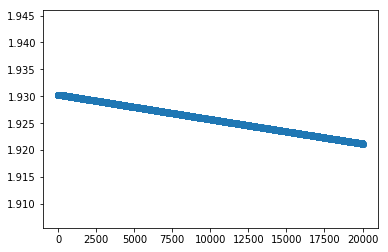

In [661]:
plt.scatter(epoch,Error)

In [662]:
np.max(w_best)

23.183330017603456

In [663]:
p_val=softmax(X_val,w_best)
y_pred=np.rint(p_val)

In [664]:
y_pred.shape

(162, 8)

In [665]:
((y_pred == y_val).mean()*100)

100.0

In [666]:
((y_pred[(y_pred==y_val) & (y_pred==1)].shape[1]/y_val[y_val==1].shape[1]))*100

100.0

In [667]:
p_test=softmax(X_test,w_best)
y_pred=np.rint(p_test)

In [709]:
acc=((y_pred == y_test).mean(0)*100)

In [701]:
((y_pred[(y_pred==y_test) & (y_pred==1)].shape[1]/y_test[y_test==1].shape[1]))*100

98.76543209876543

In [670]:
mi_prot=np.argpartition(w, -5, axis=0)[-5:,:]

In [671]:
#Order of columns. c is control, 
col_order=['c-CS-m','c-CS-s','c-SC-m','c-SC-s','t-CS-m','t-CS-s','t-SC-m','t-SC-s']


In [672]:
print('c-CS-m','c-CS-s','c-SC-m','c-SC-s','t-CS-m','t-CS-s','t-SC-m','t-SC-s')
print(mi_prot)

c-CS-m c-CS-s c-SC-m c-SC-s t-CS-m t-CS-s t-SC-m t-SC-s
[[67 77 35 35 64 12 33 32]
 [59 22 61 33 70 18 42 33]
 [25 63 73 73 31 49 55 46]
 [56 40  8 34  2 31 63 47]
 [12 18 16 20 77 44 31 42]]


In [673]:
prot_list[73]

'H3AcK18_N'

In [674]:
prot_list[31]

'Bcatenin_N'

In [675]:
prot_list[33]

'MTOR_N'

In [676]:
prot_list[42]

'pP70S6_N'

In [680]:
prot_ranks=np.array(prot_list)[mi_prot.T-1]

In [681]:
#Subtract on to reflect that there is a bisa column in X,  ut not in the headers of the array. 
#Fortunately bias is not in mi_prot, otherwise I would need a different solution
prot_dict = {a : b for a,b in zip(col_order,prot_ranks.tolist())}

In [687]:
prot_dict

{'c-CS-m': ['pGSK3B_Tyr216_N', 'GluR3_N', 'ERK_N', 'nNOS_N', 'pJNK_N'],
 'c-CS-s': ['CaNA_N', 'CAMKII_N', 'pCASP9_N', 'pNUMB_N', 'pPKCAB_N'],
 'c-SC-m': ['P38_N', 'IL1B_N', 'SYP_N', 'pCAMKII_N', 'pNR2A_N'],
 'c-SC-s': ['P38_N', 'SOD1_N', 'SYP_N', 'MTOR_N', 'AKT_N'],
 't-CS-m': ['PSD95_N', 'BCL2_N', 'APP_N', 'ITSN1_N', 'CaNA_N'],
 't-CS-s': ['pJNK_N', 'pPKCAB_N', 'S6_N', 'APP_N', 'NUMB_N'],
 't-SC-m': ['SOD1_N', 'TIAM1_N', 'ERBB4_N', 'pCASP9_N', 'APP_N'],
 't-SC-s': ['Bcatenin_N', 'SOD1_N', 'pGSK3B_N', 'pPKCG_N', 'TIAM1_N']}

In [722]:
recalls=np.where(((y_pred==y_test) & (y_pred==1)), y_pred,0).sum(0)/y_test.sum(0)*100

In [723]:
acc_dict = {a : b for a,b in zip(col_order,np.hstack((acc.T,recalls.T)).tolist())}

In [724]:
acc_dict

{'c-CS-m': [99.38271604938271, 93.75],
 'c-CS-s': [99.38271604938271, 100.0],
 'c-SC-m': [100.0, 100.0],
 'c-SC-s': [100.0, 100.0],
 't-CS-m': [98.76543209876543, 94.44444444444444],
 't-CS-s': [100.0, 100.0],
 't-SC-m': [100.0, 100.0],
 't-SC-s': [100.0, 100.0]}

In [726]:
np.sum(data[:,77])

150.0

In [728]:
np.sum(data[:,78])

135.0

In [729]:
np.sum(data[:,79])

150.0

In [730]:
np.sum(data[:,80])

135.0

In [727]:
np.sum(data[:,81])

135.0

In [731]:
np.sum(data[:,82])

105.0

In [732]:
np.sum(data[:,83])

135.0

In [733]:
np.sum(data[:,84])

135.0